In [1]:
from jax import random
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS

import constants as cs
import distributions as dist
import data_generation as data_gen

In [2]:
import warnings
warnings.filterwarnings('ignore')

# HMC NUTS

In [3]:
initial_parameters = jnp.concatenate([cs.MU_PHI, cs.TAU_PHI_MAP, data_gen.all_sampled_params_concat])
initial_parameters

Array([ 0.6931472 ,  1.0986123 ,  0.96000004,  0.8       ,  0.36540878,
       -0.7256274 ,  2.090436  ,  1.0174242 ,  0.69884956,  1.8649924 ,
       -1.960983  ,  2.8546095 ], dtype=float32)

In [4]:
# # Add some noise to initial parameters for different chains
# noise_scale = 0.1
# initial_params_noisy = initial_parameters + random.normal(random.key(0), 
#                                                         (number_of_chains, len(initial_parameters))) * noise_scale

In [5]:
initial_params_tiled = jnp.tile(initial_parameters, (cs.N_CHAINS, 1))
initial_params_tiled

Array([[ 0.6931472 ,  1.0986123 ,  0.96000004,  0.8       ,  0.36540878,
        -0.7256274 ,  2.090436  ,  1.0174242 ,  0.69884956,  1.8649924 ,
        -1.960983  ,  2.8546095 ],
       [ 0.6931472 ,  1.0986123 ,  0.96000004,  0.8       ,  0.36540878,
        -0.7256274 ,  2.090436  ,  1.0174242 ,  0.69884956,  1.8649924 ,
        -1.960983  ,  2.8546095 ]], dtype=float32)

In [6]:
kernel = NUTS(potential_fn=dist.log_posterior_distribution)
            #  dense_mass=False,          
            #  step_size=1e-2,           
            #  target_accept_prob=0.85)

In [7]:
mcmc = MCMC(kernel, 
            num_warmup=2000, 
            num_samples=2000,
            num_chains=cs.N_CHAINS,
            chain_method='parallel')

In [8]:
# Create multiple random keys for different chains
rng_keys = random.split(random.key(0), cs.N_CHAINS)
mcmc.run(rng_keys, init_params=initial_params_tiled)

sample: 100%|██████████| 4000/4000 [06:32<00:00, 10.19it/s, 15 steps of size 2.02e-01. acc. prob=0.87]   


In [ ]:
samples = mcmc.get_samples()
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 Param:0[0]      0.56      0.51      0.57     -0.28      1.38   2701.17      1.00
 Param:0[1]      1.19      0.52      1.18      0.30      1.97   2660.76      1.00
 Param:0[2]      1.52      0.55      1.40      0.72      2.32   1089.11      1.00
 Param:0[3]      1.39      0.46      1.30      0.78      2.02   1357.22      1.00
 Param:0[4]      0.37      0.00      0.37      0.36      0.37   4053.10      1.00
 Param:0[5]     -0.73      0.01     -0.73     -0.73     -0.72   4178.64      1.00
 Param:0[6]      2.09      0.01      2.09      2.08      2.10   3455.99      1.00
 Param:0[7]      1.02      0.04      1.02      0.95      1.09   2961.75      1.00
 Param:0[8]      0.70      0.01      0.70      0.69      0.71   3341.11      1.00
 Param:0[9]      1.87      0.02      1.86      1.84      1.89   2769.20      1.00
Param:0[10]     -1.58      0.87     -1.34     -2.70     -0.47    991.22      1.00
Param:0[11]    

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def plot_mcmc_diagnostics(samples, true_params=None, n_chains=2):
    """
    Create comprehensive MCMC diagnostic plots including chains and violin plots
    for hyperparameters only (μ_1, μ_2, τ_1, τ_2)
    """
    # Generate parameter names for hyperparameters only
    param_names = [
        'μ_1', 'μ_2',                     # Population means (2)
        'τ_1', 'τ_2'                      # Population std devs (2)
    ]
    
    # Select only the first 4 columns (hyperparameters)
    samples = samples[:, :4]
    if true_params is not None:
        true_params = true_params[:4]
    
    n_params = samples.shape[1]
    samples_per_chain = len(samples) // n_chains
    
    # Create figure
    fig = plt.figure(figsize=(20, 4*n_params))
    gs = plt.GridSpec(n_params, 2, width_ratios=[2, 1])
    
    # Set colors for chains
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'][:n_chains]
    
    for i in range(n_params):
        # Trace plot (chains)
        ax_trace = fig.add_subplot(gs[i, 0])
        
        # Plot each chain
        for chain in range(n_chains):
            chain_samples = samples[chain*samples_per_chain:(chain+1)*samples_per_chain, i]
            ax_trace.plot(np.arange(samples_per_chain), chain_samples, 
                         alpha=0.7, color=colors[chain], 
                         label=f'Chain {chain+1}')
        
        # Add true value line if provided
        if true_params is not None:
            ax_trace.axhline(y=true_params[i], color='r', linestyle='--', 
                           alpha=0.8, label='True Value')
        
        # Customize trace plot
        ax_trace.set_title(f'Trace Plot - {param_names[i]}')
        ax_trace.set_xlabel('Iteration')
        ax_trace.set_ylabel('Value')
        if i == 0:
            ax_trace.legend()
        
        # Violin plot
        ax_violin = fig.add_subplot(gs[i, 1])
        
        # Create violin plot
        violin_data = []
        for chain in range(n_chains):
            chain_samples = samples[chain*samples_per_chain:(chain+1)*samples_per_chain, i]
            violin_data.append(chain_samples)
        
        parts = ax_violin.violinplot(violin_data, points=100, vert=True, widths=0.7,
                                   showmeans=True, showextrema=True, showmedians=True)
        
        # Customize violin plot
        for pc in parts['bodies']:
            pc.set_facecolor('#D43F3A')
            pc.set_alpha(0.3)
        
        parts['cmeans'].set_color('black')
        parts['cmedians'].set_color('blue')
        
        # Add true value if provided
        if true_params is not None:
            ax_violin.axhline(y=true_params[i], color='r', linestyle='--', alpha=0.8)
        
        ax_violin.set_title(f'Distribution - {param_names[i]}')
        ax_violin.set_xticks([1])
        ax_violin.set_xticklabels([param_names[i]])
    
    plt.tight_layout()
    return fig

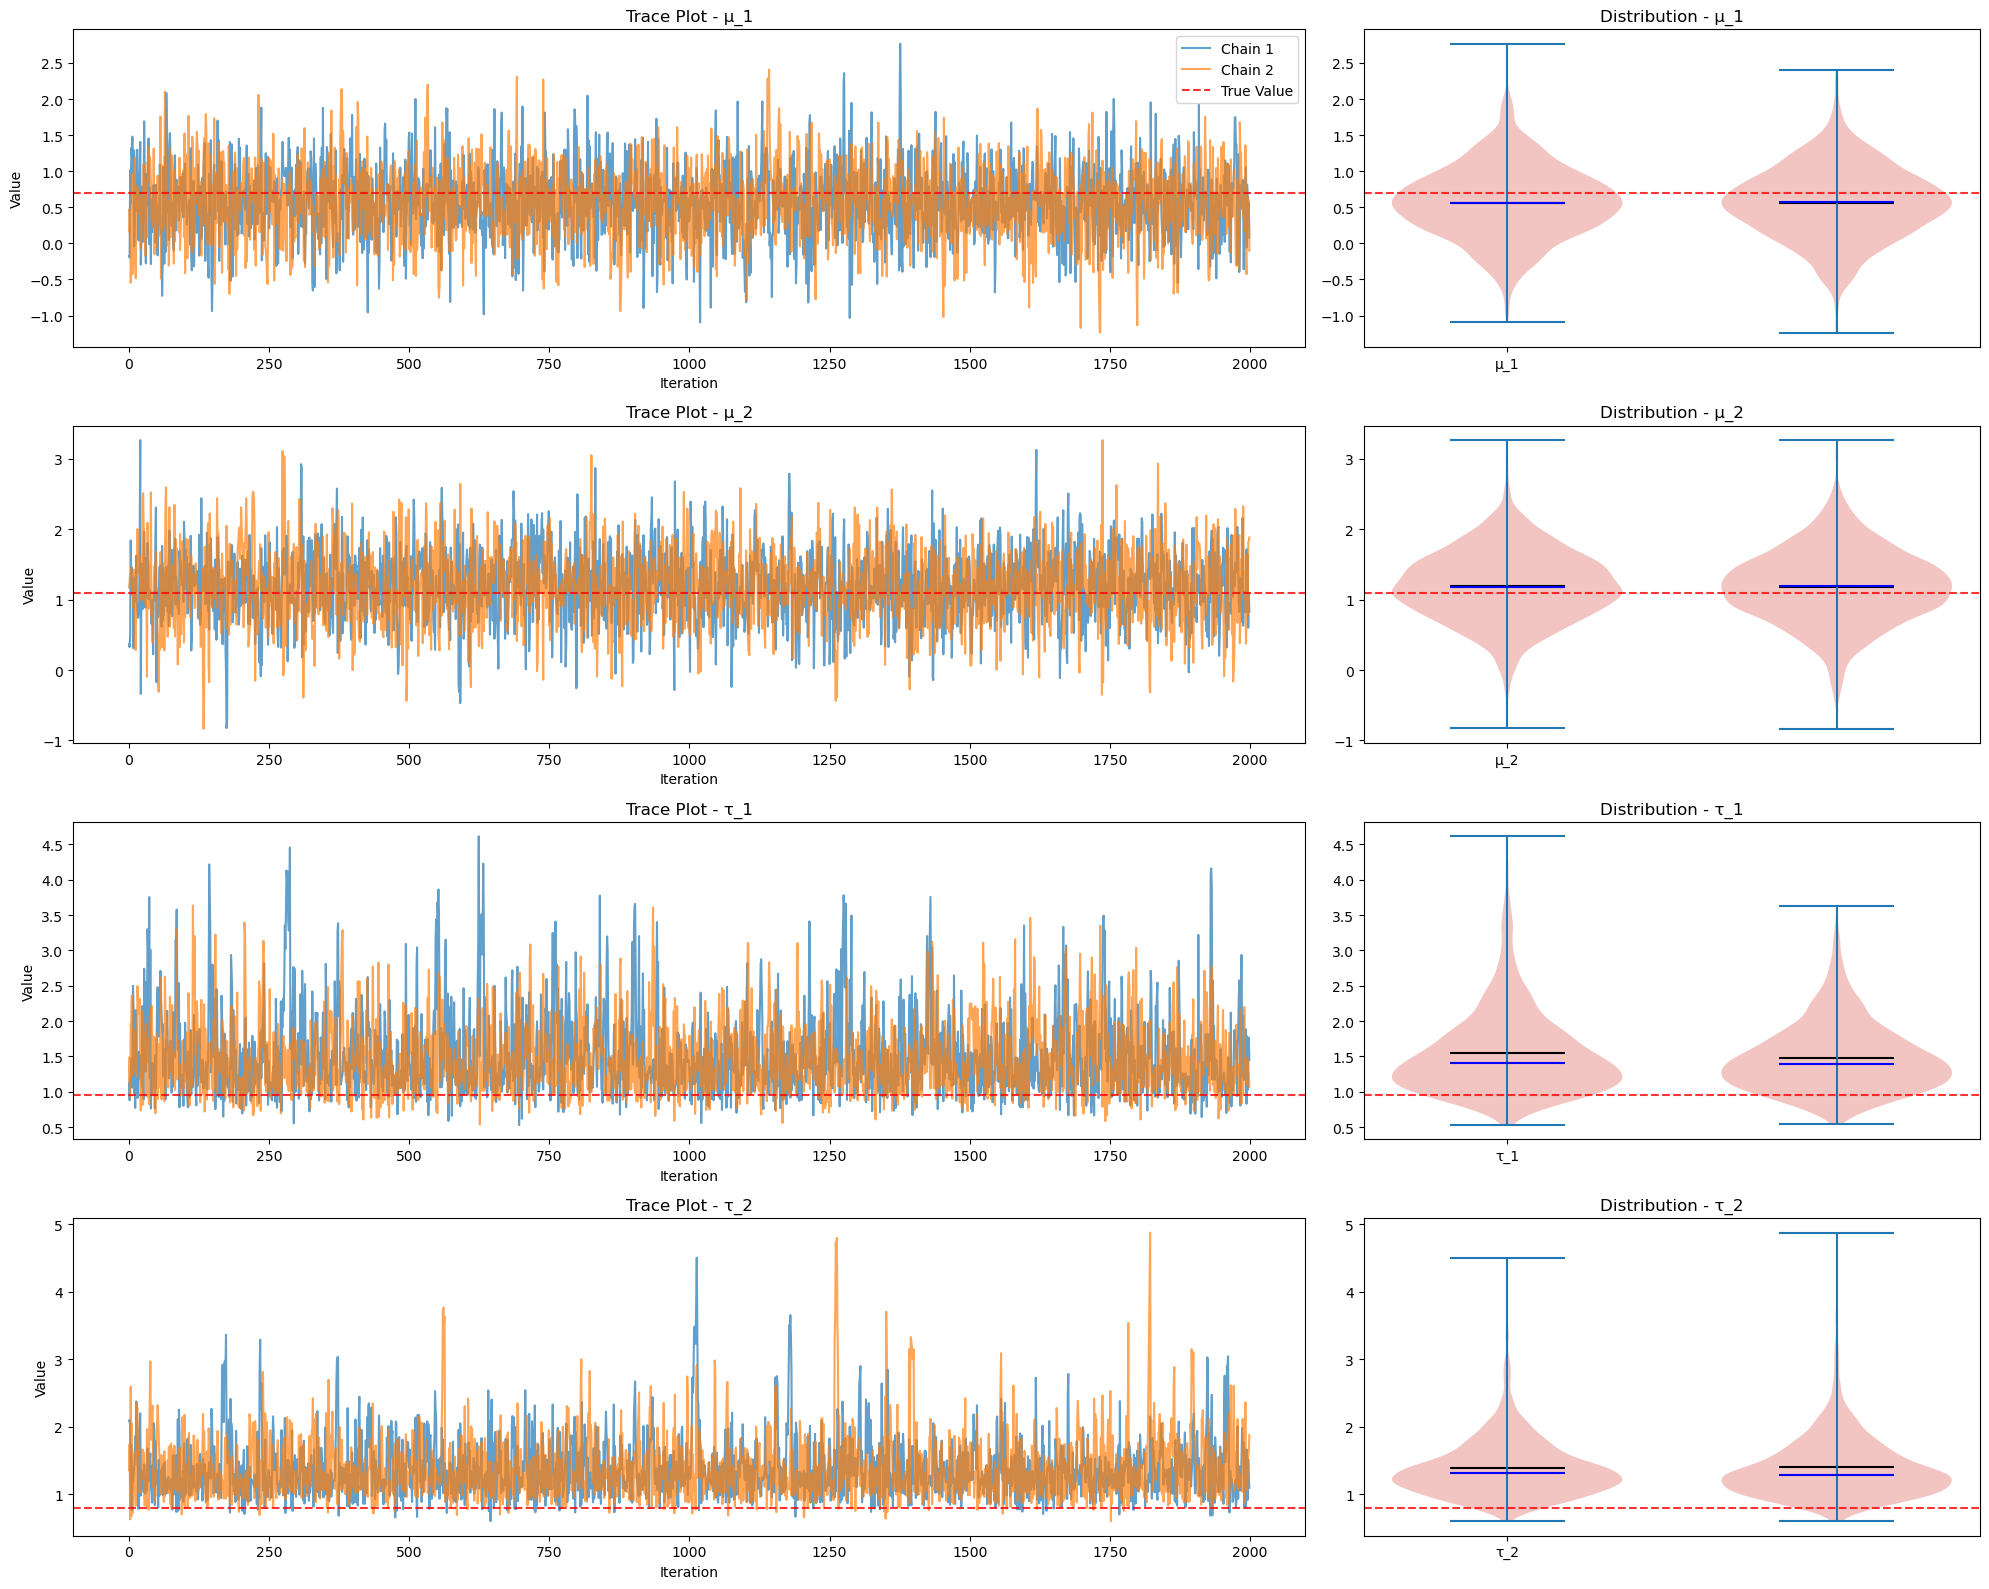

In [12]:
fig1 = plot_mcmc_diagnostics(samples, initial_parameters)
plt.show()